In [1]:
!python --version

Python 3.12.10


In [2]:
import numpy as np
import open3d as o3d
from scipy.ndimage import gaussian_filter
from pathlib import Path
from itertools import chain
from tqdm import tqdm
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def load_mesh(path):
    
    mesh = o3d.io.read_triangle_mesh(path)
    
    if mesh.is_empty():
        raise ValueError(f"Failed to load mesh or mesh is empty: {path}")
    if not mesh.has_triangles():
        raise ValueError("Loaded geometry has no triangles (not a TriangleMesh).")
    
    mesh.remove_duplicated_vertices()
    mesh.remove_duplicated_triangles()
    mesh.remove_degenerate_triangles()
    mesh.remove_unreferenced_vertices()
    mesh.compute_vertex_normals()
    
    return mesh

In [4]:
def _copy_mesh(mesh: o3d.geometry.TriangleMesh) -> o3d.geometry.TriangleMesh:
    
    m = o3d.geometry.TriangleMesh(mesh)
    m.vertices = o3d.utility.Vector3dVector(np.asarray(mesh.vertices).copy())
    m.triangles = o3d.utility.Vector3iVector(np.asarray(mesh.triangles).copy())
    if mesh.has_vertex_normals():
        m.vertex_normals = o3d.utility.Vector3dVector(np.asarray(mesh.vertex_normals).copy())
    if mesh.has_triangle_normals():
        m.triangle_normals = o3d.utility.Vector3dVector(np.asarray(mesh.triangle_normals).copy())
    return m

In [5]:
def normalize_to_unit_sphere(mesh: o3d.geometry.TriangleMesh, eps: float = 1e-12):
    """
    Centers mesh at origin (centroid of vertices) and scales so max vertex radius = 1.
    Returns (mesh_normalized, T_norm), where T_norm maps original -> normalized.
    """
    m = _copy_mesh(mesh)
    V = np.asarray(m.vertices)
    c = V.mean(axis=0)
    Vc = V - c
    r = np.linalg.norm(Vc, axis=1).max()
    s = 1.0 / max(r, eps)
    Vn = Vc * s
    m.vertices = o3d.utility.Vector3dVector(Vn)
    m.compute_vertex_normals()

    T = np.eye(4)
    T[:3, :3] *= s
    T[:3, 3] = -s * c
    return m, T

In [6]:
def compute_sdf_grid(mesh, res=128, padding=0.05, bounds=None, signed=True):
    """
    If bounds is None: uses mesh AABB (+padding)
    If bounds=(mn,mx): uses that fixed box (recommended for comparing volumes)
    signed=True  -> signed distance
    signed=False -> unsigned distance
    """
    if bounds is None:
        aabb = mesh.get_axis_aligned_bounding_box()
        mn = aabb.get_min_bound()
        mx = aabb.get_max_bound()
        diag = np.linalg.norm(mx - mn)
        pad = padding * diag
        mn = mn - pad
        mx = mx + pad
    else:
        mn, mx = bounds

    # build raycasting scene
    tmesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
    scene = o3d.t.geometry.RaycastingScene()
    _ = scene.add_triangles(tmesh)

    xs = np.linspace(mn[0], mx[0], res)
    ys = np.linspace(mn[1], mx[1], res)
    zs = np.linspace(mn[2], mx[2], res)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    pts = np.stack([X, Y, Z], axis=-1).reshape(-1, 3).astype(np.float32)
    pts_t = o3d.core.Tensor(pts, dtype=o3d.core.Dtype.Float32)

    if signed:
        sdf = scene.compute_signed_distance(pts_t).numpy()
    else:
        sdf = scene.compute_distance(pts_t).numpy()

    return sdf.reshape(res, res, res), (mn, mx)

## Execute SDFD with pre-oriented Scans (.ply from Auto3dgm)

### 1) Using pre-aligned Scans (good) -- Using original Scans (bad)

## Execute SDFD with original data but align using a template

In [7]:
def get_canonical_bounds_cube(R: float = 1.05):
    """Fixed SDF bounds for all meshes after unit-sphere normalization."""
    mn = np.array([-R, -R, -R], dtype=np.float32)
    mx = np.array([ R,  R,  R], dtype=np.float32)
    return (mn, mx)

In [8]:
def _ensure_normals(pcd: o3d.geometry.PointCloud, radius: float):
    if not pcd.has_normals():
        pcd.estimate_normals(
            search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=30)
        )
    pcd.normalize_normals()

In [9]:
def _sample_pcd(mesh: o3d.geometry.TriangleMesh, n_points: int):
    # Poisson disk is robust but can fail on some meshes; fallback to uniform.
    try:
        pcd = mesh.sample_points_poisson_disk(number_of_points=n_points, init_factor=5)
    except Exception:
        pcd = mesh.sample_points_uniformly(number_of_points=n_points)
    return pcd

In [10]:
def _rotation_candidates():
    """
    24 proper rotations (det=+1): all axis permutations with sign flips
    that map the basis onto itself (the rotational symmetry group of the cube).
    This is a great discrete multi-start set for ICP on bones.
    """
    rots = []
    axes = np.eye(3)

    # All permutations of x,y,z axes
    import itertools
    for perm in itertools.permutations([0, 1, 2], 3):
        P = axes[:, perm]  # permutation matrix

        # All sign flip combinations
        for signs in itertools.product([-1, 1], repeat=3):
            S = np.diag(signs)
            R = P @ S

            # keep only proper rotations (no reflection)
            if np.linalg.det(R) > 0.0:
                rots.append(R.astype(np.float64))

    # optional: unique (should already be 24, but numeric safety)
    unique = []
    for R in rots:
        if not any(np.allclose(R, Q) for Q in unique):
            unique.append(R)

    # sanity check
    assert len(unique) == 24, f"Expected 24 rotations, got {len(unique)}"
    return unique

In [11]:
def align_to_template_robust(
    mesh: o3d.geometry.TriangleMesh,
    template_mesh: o3d.geometry.TriangleMesh,
    *,
    n_points: int = 6000,
    voxel_size: float = 0.03,
    icp_distance: float = 0.08,
    max_iter: int = 80,
    prefer_fitness: bool = True,
    debug: bool = False,
):
    """
    Robustly align mesh -> template_mesh.
    Pipeline:
      1) normalize both to unit sphere
      2) try several discrete rotation initializations
      3) ICP refine (point-to-plane if normals exist)
      4) pick best by (fitness desc, rmse asc) or (rmse asc)

    Returns:
      aligned_mesh_norm (in normalized space),
      T_total (4x4) mapping ORIGINAL mesh -> TEMPLATE-normalized space,
      fixed_bounds (canonical cube bounds for SDF),
      best_info (dict with fitness/rmse)
    """
    # Normalize both to unit sphere (critical for fixed SDF bounds consistency)
    mesh_n, Tn_mesh = normalize_to_unit_sphere(mesh)
    templ_n, Tn_templ = normalize_to_unit_sphere(template_mesh)

    # Canonical SDF bounds (avoid template-AABB clipping)
    fixed_bounds = get_canonical_bounds_cube(R=1.05)

    # Sample point clouds
    src_full = _sample_pcd(mesh_n, n_points)
    tgt_full = _sample_pcd(templ_n, n_points)

    # Downsample for ICP
    src = src_full.voxel_down_sample(voxel_size=voxel_size)
    tgt = tgt_full.voxel_down_sample(voxel_size=voxel_size)

    # Normals help point-to-plane ICP a lot
    _ensure_normals(src, radius=voxel_size * 2.5)
    _ensure_normals(tgt, radius=voxel_size * 2.5)

    best = None
    best_T = None
    best_info = None

    # ICP criteria
    criteria = o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iter)
    est = o3d.pipelines.registration.TransformationEstimationPointToPlane()

    for i, R0 in enumerate(_rotation_candidates()):
        T0 = np.eye(4)
        T0[:3, :3] = R0

        # Run ICP
        reg = o3d.pipelines.registration.registration_icp(
            src, tgt,
            max_correspondence_distance=icp_distance,
            init=T0,
            estimation_method=est,
            criteria=criteria
        )

        info = {"fitness": reg.fitness, "rmse": reg.inlier_rmse, "init_idx": i}
        if debug:
            print("start", i, "fitness", reg.fitness, "rmse", reg.inlier_rmse)

        if best is None:
            best = reg
            best_T = reg.transformation
            best_info = info
            continue

        if prefer_fitness:
            # Higher fitness first, then lower rmse
            if (info["fitness"] > best_info["fitness"] + 1e-6) or (
                abs(info["fitness"] - best_info["fitness"]) <= 1e-6 and info["rmse"] < best_info["rmse"]
            ):
                best = reg
                best_T = reg.transformation
                best_info = info
        else:
            # Pure rmse minimization
            if info["rmse"] < best_info["rmse"]:
                best = reg
                best_T = reg.transformation
                best_info = info

    # Apply best transform to the normalized mesh
    aligned_n = _copy_mesh(mesh_n)
    aligned_n.transform(best_T)

    # T_total maps ORIGINAL mesh -> TEMPLATE-normalized space:
    # original --(Tn_mesh)--> mesh_normalized --(best_T)--> aligned_in_template_normalized
    T_total = best_T @ Tn_mesh

    return aligned_n, T_total, fixed_bounds, best_info

In [12]:
def show_alignment(template_mesh, mesh, title="QC"):
    tm = _copy_mesh(template_mesh); tm.paint_uniform_color([0.8,0.8,0.8])
    mm = _copy_mesh(mesh);          mm.paint_uniform_color([0.95,0.55,0.10])
    frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2)
    o3d.visualization.draw_geometries([tm, mm, frame], window_name=title)

### 2) PCA + ICP

In [13]:
obj_dir = [Path("data/OvisAries"), Path("data/GazellaSubgutturosa")]
files = list(chain.from_iterable(sorted(d.glob("*.obj")) for d in obj_dir))

names = []
labels = []
aligned_meshes = []
descriptors = []
descriptors_smooth = []

RES = 128
PADDING = 0.05
SIGMA = 2

fixed_bounds = get_canonical_bounds_cube(R=1+PADDING)

# Optional: Save one each for plotting
template_mesh = None
gazelle_mesh = None

# Choose a random bone as template


for idx, obj_path in enumerate(tqdm(files)):
#for idx, obj_path in enumerate(tqdm(files[28:31])): # used to debug stubborn bone

    names.append(f"{obj_path.parent.name}-{obj_path.stem.rsplit('-', 1)[-1]}")
    labels.append(0 if obj_path.parts[1].lower().startswith("ovis") else 1) if len(obj_path.parts) > 1 else labels.append(0)

    if idx == 0:
        template_mesh = load_mesh(files[idx])
        #template_mesh.compute_vertex_normals()  # done in load_mesh

        template_mesh, _ = normalize_to_unit_sphere(template_mesh)
        #o3d.io.write_triangle_mesh("SDFD_sheep_mesh.ply", template_mesh)
        aligned_meshes.append(template_mesh)

        template_sdf, _ = compute_sdf_grid(
            template_mesh,
            res=RES,
            padding=PADDING,
            bounds=fixed_bounds,  
            signed=True
        )

        sdf_tem_smooth = gaussian_filter(template_sdf, sigma=SIGMA)
        descriptors.append(template_sdf)
        descriptors_smooth.append(sdf_tem_smooth)
        continue
        
    mesh = load_mesh(obj_path)
    #mesh.compute_vertex_normals()  # done in load_mesh

    aligned_mesh_norm, T_total, fixed_bounds, info = align_to_template_robust(
        mesh,
        template_mesh,
        n_points=10000,
        voxel_size=0.03,
        icp_distance=0.08,
        max_iter=80,
        debug=False,
    )

    # QC
    #print(info)
    #V = np.asarray(aligned_mesh_norm.vertices)
    #print("radius max:", np.linalg.norm(V, axis=1).max(), "mean:", np.linalg.norm(V, axis=1).mean())
    #print("centroid:", V.mean(axis=0))
    
    #show_alignment(template_mesh, aligned_mesh_norm, title=f"IS IT ALIGNED? {obj_path.name}")
    aligned_meshes.append(aligned_mesh_norm)

    if idx + 1 == len(files):
        print("Saved to compare", names[idx])
        gazelle_mesh = aligned_mesh_norm
        #o3d.io.write_triangle_mesh("SDFD_gazelle_mesh.ply", gazelle_mesh)

    sdf, _ = compute_sdf_grid(
        aligned_mesh_norm,
        res=RES,
        padding=PADDING,
        bounds=fixed_bounds,
        signed=True
    )

    sdf_smooth = gaussian_filter(sdf, sigma=SIGMA)
    descriptors.append(sdf)
    descriptors_smooth.append(sdf_smooth)

print("Template used:", names[0])
print("Descriptors:", len(descriptors), "each with shape", np.asarray(descriptors[0]).shape)

  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


  1%|▉                                                                                  | 1/85 [00:07<10:43,  7.65s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


  2%|█▉                                                                                 | 2/85 [00:31<23:45, 17.18s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


  4%|██▉                                                                                | 3/85 [00:53<26:17, 19.24s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


  5%|███▉                                                                               | 4/85 [01:16<27:55, 20.69s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


  6%|████▉                                                                              | 5/85 [01:42<30:11, 22.65s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


  7%|█████▊                                                                             | 6/85 [02:07<31:05, 23.61s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


  8%|██████▊                                                                            | 7/85 [02:32<31:09, 23.97s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


  9%|███████▊                                                                           | 8/85 [02:58<31:30, 24.56s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 11%|████████▊                                                                          | 9/85 [03:23<31:25, 24.81s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 12%|█████████▋                                                                        | 10/85 [03:47<30:45, 24.60s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 13%|██████████▌                                                                       | 11/85 [04:11<29:58, 24.31s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 14%|███████████▌                                                                      | 12/85 [04:38<30:39, 25.20s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 15%|████████████▌                                                                     | 13/85 [05:03<30:07, 25.10s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 16%|█████████████▌                                                                    | 14/85 [05:28<29:46, 25.17s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 18%|██████████████▍                                                                   | 15/85 [05:53<29:13, 25.05s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 19%|███████████████▍                                                                  | 16/85 [06:18<28:41, 24.95s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 20%|████████████████▍                                                                 | 17/85 [06:42<28:00, 24.72s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 21%|█████████████████▎                                                                | 18/85 [07:05<27:09, 24.32s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 22%|██████████████████▎                                                               | 19/85 [07:37<29:15, 26.61s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 24%|███████████████████▎                                                              | 20/85 [08:03<28:40, 26.48s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 25%|████████████████████▎                                                             | 21/85 [08:31<28:33, 26.78s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 26%|█████████████████████▏                                                            | 22/85 [08:59<28:34, 27.22s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 27%|██████████████████████▏                                                           | 23/85 [09:24<27:29, 26.60s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 28%|███████████████████████▏                                                          | 24/85 [09:51<26:54, 26.47s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 29%|████████████████████████                                                          | 25/85 [10:17<26:20, 26.35s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 31%|█████████████████████████                                                         | 26/85 [10:41<25:28, 25.91s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 32%|██████████████████████████                                                        | 27/85 [11:08<25:13, 26.10s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 33%|███████████████████████████                                                       | 28/85 [11:35<25:04, 26.40s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 34%|███████████████████████████▉                                                      | 29/85 [12:02<24:44, 26.50s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 35%|████████████████████████████▉                                                     | 30/85 [12:26<23:43, 25.89s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 36%|█████████████████████████████▉                                                    | 31/85 [12:51<22:54, 25.46s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 38%|██████████████████████████████▊                                                   | 32/85 [13:17<22:34, 25.56s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 39%|███████████████████████████████▊                                                  | 33/85 [13:43<22:20, 25.77s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 40%|████████████████████████████████▊                                                 | 34/85 [14:11<22:26, 26.40s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 41%|█████████████████████████████████▊                                                | 35/85 [14:38<22:18, 26.77s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 42%|██████████████████████████████████▋                                               | 36/85 [15:02<21:03, 25.78s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 44%|███████████████████████████████████▋                                              | 37/85 [15:24<19:46, 24.72s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 45%|████████████████████████████████████▋                                             | 38/85 [15:46<18:48, 24.02s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 46%|█████████████████████████████████████▌                                            | 39/85 [16:10<18:19, 23.90s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 47%|██████████████████████████████████████▌                                           | 40/85 [16:36<18:20, 24.46s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 48%|███████████████████████████████████████▌                                          | 41/85 [17:00<17:55, 24.43s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 49%|████████████████████████████████████████▌                                         | 42/85 [17:25<17:38, 24.62s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 51%|█████████████████████████████████████████▍                                        | 43/85 [17:54<18:01, 25.75s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 52%|██████████████████████████████████████████▍                                       | 44/85 [18:17<17:03, 24.96s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 53%|███████████████████████████████████████████▍                                      | 45/85 [18:44<17:09, 25.74s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 54%|████████████████████████████████████████████▍                                     | 46/85 [19:10<16:42, 25.70s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 55%|█████████████████████████████████████████████▎                                    | 47/85 [19:37<16:34, 26.17s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 56%|██████████████████████████████████████████████▎                                   | 48/85 [20:03<15:59, 25.94s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 58%|███████████████████████████████████████████████▎                                  | 49/85 [20:35<16:49, 28.03s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 59%|████████████████████████████████████████████████▏                                 | 50/85 [21:04<16:24, 28.14s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 60%|█████████████████████████████████████████████████▏                                | 51/85 [21:32<15:54, 28.09s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 61%|██████████████████████████████████████████████████▏                               | 52/85 [21:53<14:20, 26.08s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 62%|███████████████████████████████████████████████████▏                              | 53/85 [22:17<13:36, 25.51s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 64%|████████████████████████████████████████████████████                              | 54/85 [22:42<13:02, 25.23s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 65%|█████████████████████████████████████████████████████                             | 55/85 [23:08<12:40, 25.34s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 66%|██████████████████████████████████████████████████████                            | 56/85 [23:31<11:56, 24.70s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 67%|██████████████████████████████████████████████████████▉                           | 57/85 [23:57<11:45, 25.19s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 68%|███████████████████████████████████████████████████████▉                          | 58/85 [24:20<11:03, 24.56s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 69%|████████████████████████████████████████████████████████▉                         | 59/85 [24:45<10:42, 24.72s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 71%|█████████████████████████████████████████████████████████▉                        | 60/85 [25:12<10:36, 25.45s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 72%|██████████████████████████████████████████████████████████▊                       | 61/85 [25:37<10:05, 25.22s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 73%|███████████████████████████████████████████████████████████▊                      | 62/85 [26:06<10:03, 26.25s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 74%|████████████████████████████████████████████████████████████▊                     | 63/85 [26:28<09:09, 24.98s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 75%|█████████████████████████████████████████████████████████████▋                    | 64/85 [26:57<09:13, 26.36s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 76%|██████████████████████████████████████████████████████████████▋                   | 65/85 [27:25<08:51, 26.59s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 78%|███████████████████████████████████████████████████████████████▋                  | 66/85 [27:52<08:29, 26.80s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 79%|████████████████████████████████████████████████████████████████▋                 | 67/85 [28:17<07:53, 26.31s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 80%|█████████████████████████████████████████████████████████████████▌                | 68/85 [28:49<07:57, 28.10s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 81%|██████████████████████████████████████████████████████████████████▌               | 69/85 [29:17<07:26, 27.92s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 82%|███████████████████████████████████████████████████████████████████▌              | 70/85 [29:41<06:43, 26.87s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 84%|████████████████████████████████████████████████████████████████████▍             | 71/85 [30:07<06:10, 26.48s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 85%|█████████████████████████████████████████████████████████████████████▍            | 72/85 [30:33<05:44, 26.46s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 86%|██████████████████████████████████████████████████████████████████████▍           | 73/85 [31:03<05:28, 27.41s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 87%|███████████████████████████████████████████████████████████████████████▍          | 74/85 [31:29<04:57, 27.01s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 88%|████████████████████████████████████████████████████████████████████████▎         | 75/85 [31:56<04:28, 26.90s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 89%|█████████████████████████████████████████████████████████████████████████▎        | 76/85 [32:21<03:57, 26.43s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 91%|██████████████████████████████████████████████████████████████████████████▎       | 77/85 [32:49<03:36, 27.08s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 92%|███████████████████████████████████████████████████████████████████████████▏      | 78/85 [33:17<03:10, 27.15s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 93%|████████████████████████████████████████████████████████████████████████████▏     | 79/85 [33:43<02:41, 26.88s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 80/85 [34:10<02:14, 26.92s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 95%|██████████████████████████████████████████████████████████████████████████████▏   | 81/85 [34:33<01:43, 25.79s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 96%|███████████████████████████████████████████████████████████████████████████████   | 82/85 [35:00<01:18, 26.14s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 98%|████████████████████████████████████████████████████████████████████████████████  | 83/85 [35:24<00:50, 25.32s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


 99%|█████████████████████████████████████████████████████████████████████████████████ | 84/85 [35:51<00:26, 26.07s/it]

[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
Saved to compare GazellaSubgutturosa-03045
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based mesh. Only material DefaultMaterial was converted.


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [36:15<00:00, 25.59s/it]

Template used: OvisAries-03188
Descriptors: 85 each with shape (128, 128, 128)


In [14]:
print(sdf.shape)

#print(sdf)

(128, 128, 128)


## Plot Results

#### Slice

#### Render 3D Version (aka red cube)

## Plot Pairwise Distance

In [15]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

X = np.asarray(descriptors_smooth, dtype=np.float32)
X = X.reshape(X.shape[0], -1)

# optional: normalize rows safely
norms = np.linalg.norm(X, axis=1, keepdims=True)
X = X / np.maximum(norms, 1e-12)

D = squareform(pdist(X, metric="euclidean"))
S = 1.0 / (1.0 + D)
print(D.shape)  # (85, 85)

(85, 85)


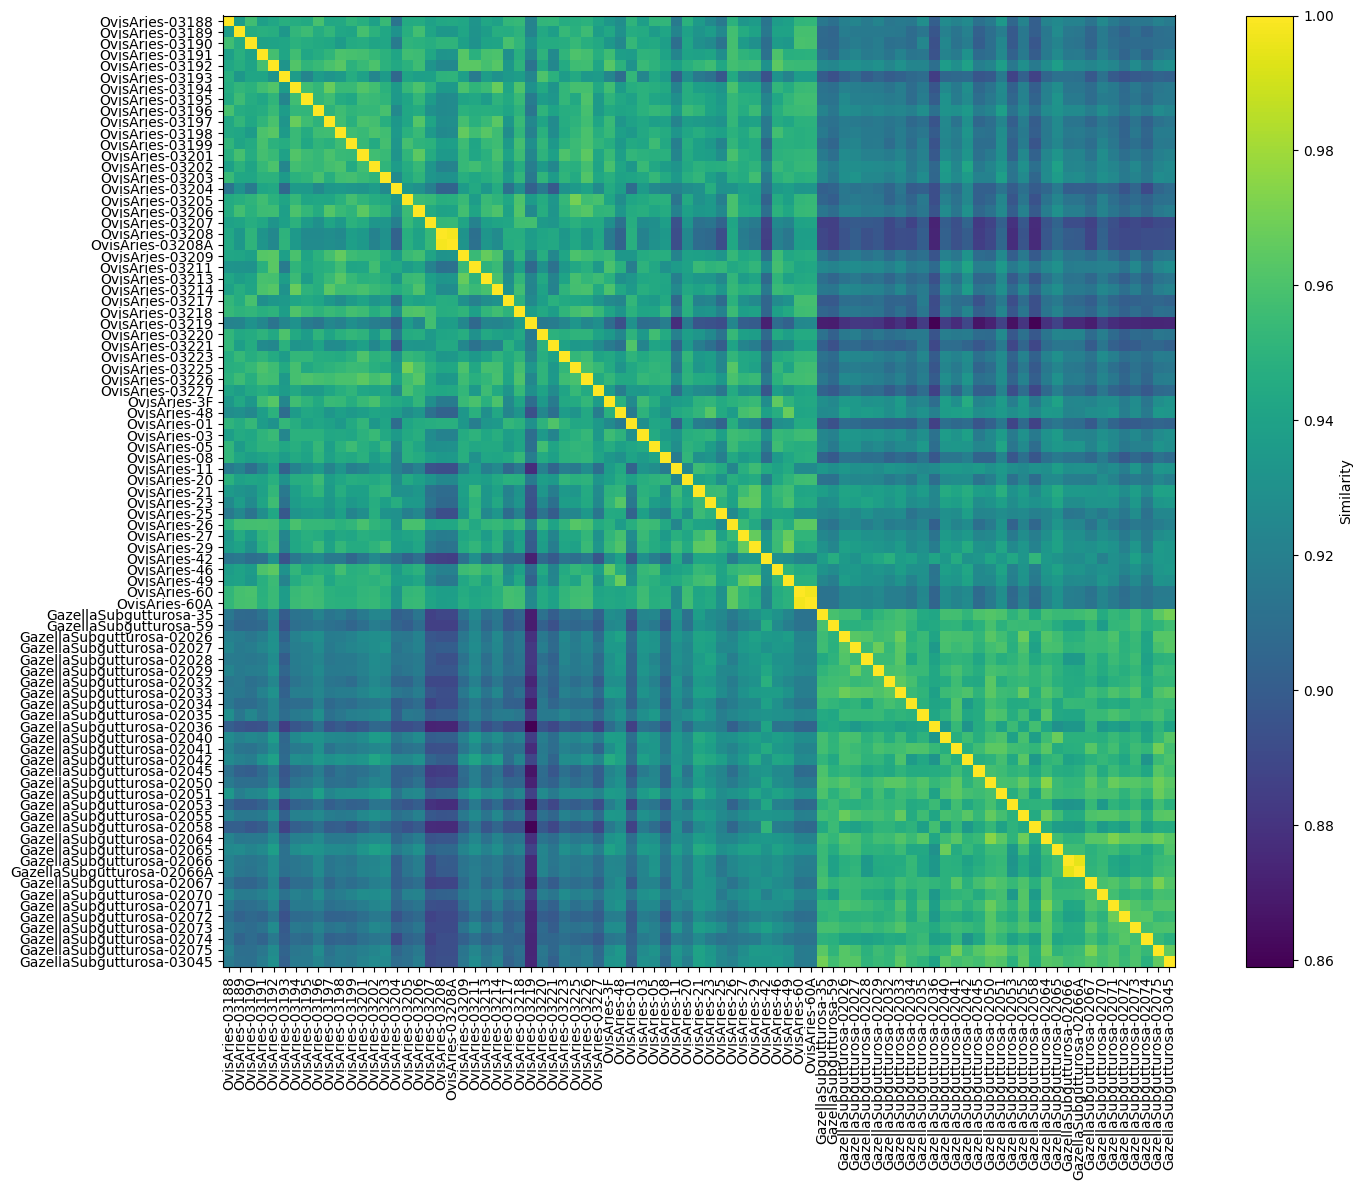

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 12))

im = ax.imshow(S, interpolation="nearest")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Similarity") # (1 / (1 + distance))")

#ax.set_title("Pairwise Similarity of SDF Descriptors")
#ax.set_xlabel("Scan")
#ax.set_ylabel("Scan")

# Tick labels (optional: for many items, this gets crowded)
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticklabels(names)

plt.tight_layout()
#plt.savefig("pairwise_similarity_sdfd_128.pdf", format="pdf", bbox_inches="tight")
#plt.savefig("pairwise_similarity_sdfd_noAlignment.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [17]:
from sklearn.metrics import silhouette_score

# D must be symmetric, zeros on diagonal
score = silhouette_score(D, labels, metric="precomputed")
print(score)

0.3547467960616058


In [18]:
# 0.009833223654963025 mit no Alignment
# 0.4266780398448826 mit auto3dgm Alignment  - 14:22
# mit eigenem Alignment
# Resolution  48: 0.3495370489942931   23:26
# Resolution  64: 0.3501479216611606   24:19  ungefähr 20s pro knochen
# Resolution  96: 0.3499785014070934          smooth: 0.35638814984269634
# Resolution 128: 0.34968489280165954  29:38  smooth: 0.35831502415574617
# Resolution 256: 0.35159987211227417 100:36  smooth: 0.35159987211227417

In [19]:
# differnence with smoothing
# 0.3493656574778767 no smoothing
# 0.35157837638166695 0.5
# 0.3546368898979223 1.0
# 0.3572080186803239 1.5

In [20]:
# Save Descriptor for Classification
np.savez(
    "Descriptors/features_SDFD_128.npz",
    X=X,
    y=labels,
    ids=names
)
print("Saved")

Saved


## Show where scans differ most

In [21]:
# Moved to a different notebook for debugging reasons